# **Validations Replication code**
This notebook replicates the main results presented in the paper.

**NB: If you want to rerun all analyses from scratch, leave the prediction folder empty. Else, uncompress the Predictions.tar.gz and place the contents in the predictions folder. In this case, no predictions are run. Instead the plots are assembled from the data in that folder**

**If you are not rerunning the analyses, you can also set import_dl_modules to false, meaning you can run this without having to install keras/tensorflow**

In [1]:
import_dl_modules = True

In [2]:
## Imports
# base python
from importlib import reload
import re
import itertools
import random
import os
from pathlib import Path
random.seed(1337)
import pickle
from decimal import Decimal
import collections

# numpy and similar
import numpy as np
np.random.seed(1337)
import pandas as pd
pd.options.mode.chained_assignment = None 
import scipy.stats as stats

# plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import plotnine

# Deep Learning related packages and scripts
if import_dl_modules:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Use gpu?
    import tensorflow as tf
    import keras
    from keras import backend as K
    from keras.models import load_model
    from keras.callbacks import ModelCheckpoint, EarlyStopping
    # modelling and utility code
    import model
    import utils_data
    import utils

# saving svg images
#from IPython.display import SVG

Using TensorFlow backend.


In [ ]:
#os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

#### Matplotlib config

In [3]:
import matplotlib_config

In [4]:
matplotlib_config.paper_config()

#### Make utility directories

In [5]:
if not os.path.exists(Path("../Graphics")):
    os.makedirs(Path("../Graphics"))
if not os.path.exists(Path("../Data/Metrics")):
    os.makedirs(Path("../Data/Metrics"))

## **Reading in the data**
Reading in the data pickle to run model training and/or evaluations

In [6]:
if import_dl_modules:
    with open(Path("../Data/data_dict.pkl"), 'rb') as handle:
        data_dict = pickle.load(handle)
    for key in data_dict:
        print(key)
        print(len(data_dict[key]))

mpra
980244
snv
1584
ptr
11575
wilhelm
5293
andreev
8003
pcr3
7672
eichhorn
8956
doudna
25831
varlen_mpra
102214


## **Import all models**
We import all the models we need to run the validations

In [8]:
if import_dl_modules:
    utr_model_50 = load_model("../Models/utr_model_50.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer}) # Framepool50
    utr_model = load_model("../Models/utr_model_100_residual.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer}) # Framepool100
    library_fn = utils_data.LibraryEncoder("library", {"egfp_unmod_1":0, "random":1})
    utr_model_combined = load_model("../Models/utr_model_combined_residual.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer}) # FramepoolCombined
    paper_model_orig = load_model("../Models/main_MRL_model.hdf5") # Optimus50
    paper_model = load_model("../Models/retrained_main_MRL_model.hdf5") 
    paper_model2 = load_model("../Models/Varying_length_25to100_model.hdf5") # Optimus100
    modelname_dict = {"Optimus50": paper_model_orig, "Framepool50": utr_model_50,
                      "Optimus100": paper_model2, "Framepool100": utr_model, "FramepoolCombined": utr_model_combined}

Instructions for updating:
Colocations handled automatically by placer.


2019-12-17 20:21:43,126 [WARNING] From /data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2019-12-17 20:21:43,316 [WARNING] From /data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.cast instead.


2019-12-17 20:21:44,947 [WARNING] From /data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


2019-12-17 20:21:45,087 [WARNING] From /data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


## **Validation on MPRA data**
We plot the performance of our models and Optimus models on MPRA data (random and human)

#### Predict for MPRA random and MPRA human

In [9]:
# Code to run a prediction on MPRA data
def predict_on_MPRA(model, data_dict, varlen = False, library = "egfp_unmod_1", min_len = None,
                    extra_encoding_fn=[], postproc_mean=5.58621521, postproc_sd=1.34657403):
    one_hot_fn = utils_data.OneHotEncoder("utr", min_len=min_len)
    if varlen:
        data_df = data_dict["varlen_mpra"].copy()
    else:
        data_df = data_dict["mpra"].copy()
    df = data_df[(data_df.library == library) & (data_df.set == "test")]
    generator = utils_data.DataSequence(df, encoding_functions=[one_hot_fn] + extra_encoding_fn, shuffle=False)
    predict = model.predict_generator(generator, verbose=0)
    if min_len is not None:
        predict = predict * postproc_sd + postproc_mean
    df["pred"] = predict.reshape(-1)
    df = df.rename(columns={"pred": "Predicted MRL", "rl": "Observed MRL"})
    return df

In [10]:
# build dataframe
def build_mpra_prediction(human=False):
    concat_df = pd.DataFrame(columns=['Predicted MRL', 'Observed MRL', 'model', 'data', 'R'])
    for modelname in ["Optimus50", "Framepool50", "Optimus100", "Framepool100", "FramepoolCombined"]:
        predmodel = modelname_dict[modelname]
        min_len = None
        if modelname == "Optimus50":
            min_len = 50
        if modelname == "Optimus100":
            min_len = 100
        extra_encoding_function = []
        if modelname == "FramepoolCombined":
            extra_encoding_function = [library_fn]
        data_types = [("Fixed length (50 nt) MPRA", "egfp_unmod_1", False), ("Variable length (25-100 nt) MPRA", "random", True)]
        if human:
            data_types = [("Fixed length (50 nt) MPRA", "human", False), ("Variable length (25-100 nt) MPRA", "human", True)]
        for data in data_types:
            varlen = data[2]
            dataname = data[0]
            library = data[1]
            pred_df = predict_on_MPRA(predmodel, data_dict, varlen = varlen, library = library, min_len = min_len,
                                     extra_encoding_fn = extra_encoding_function)
            pred_df = pred_df[["Predicted MRL", "Observed MRL"]]
            #print((modelname, dataname))
            pred_df["model"] = modelname
            pred_df["data"] = dataname
            pred_df["R"] = round(stats.pearsonr(pred_df["Predicted MRL"], pred_df["Observed MRL"])[0], 3)
            concat_df = pd.concat([concat_df, pred_df])
    return concat_df

In [11]:
# If predictions have not yet been made, make them and save
if not os.path.exists(Path("../Data/Predictions/mpra_random_prediction.csv")):
    mpra_pred_df = build_mpra_prediction()
    mpra_pred_df.to_csv(Path("../Data/Predictions/mpra_random_prediction.csv"))
if not os.path.exists(Path("../Data/Predictions/mpra_human_prediction.csv")):
    mpra_pred_df_human = build_mpra_prediction(human=True)
    mpra_pred_df_human.to_csv(Path("../Data/Predictions/mpra_human_prediction.csv"))

In [12]:
# Load predictions
mpra_pred_df = pd.read_csv(Path("../Data/Predictions/mpra_random_prediction.csv"))
mpra_pred_df_human = pd.read_csv(Path("../Data/Predictions/mpra_human_prediction.csv"))

#### Show results

In [15]:
mpra_pred_df[["model", "data", "R"]].drop_duplicates()

,model,data,R
0,Optimus50,Fixed length (50 nt) MPRA,0.966
20000,Optimus50,Variable length (25-100 nt) MPRA,0.743
27600,Framepool50,Fixed length (50 nt) MPRA,0.964
47600,Framepool50,Variable length (25-100 nt) MPRA,0.901
55200,Optimus100,Fixed length (50 nt) MPRA,0.938
75200,Optimus100,Variable length (25-100 nt) MPRA,0.915
82800,Framepool100,Fixed length (50 nt) MPRA,0.929
102800,Framepool100,Variable length (25-100 nt) MPRA,0.903
110400,FramepoolCombined,Fixed length (50 nt) MPRA,0.954
130400,FramepoolCombined,Variable length (25-100 nt) MPRA,0.914


In [16]:
mpra_pred_df_human[["model", "data", "R"]].drop_duplicates()

,model,data,R
0,Optimus50,Fixed length (50 nt) MPRA,0.889
25000,Optimus50,Variable length (25-100 nt) MPRA,0.700
32600,Framepool50,Fixed length (50 nt) MPRA,0.882
57600,Framepool50,Variable length (25-100 nt) MPRA,0.871
65200,Optimus100,Fixed length (50 nt) MPRA,0.852
90200,Optimus100,Variable length (25-100 nt) MPRA,0.882
97800,Framepool100,Fixed length (50 nt) MPRA,0.839
122800,Framepool100,Variable length (25-100 nt) MPRA,0.884
130400,FramepoolCombined,Fixed length (50 nt) MPRA,0.867
155400,FramepoolCombined,Variable length (25-100 nt) MPRA,0.894


#### Plot for MPRA random sequences

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


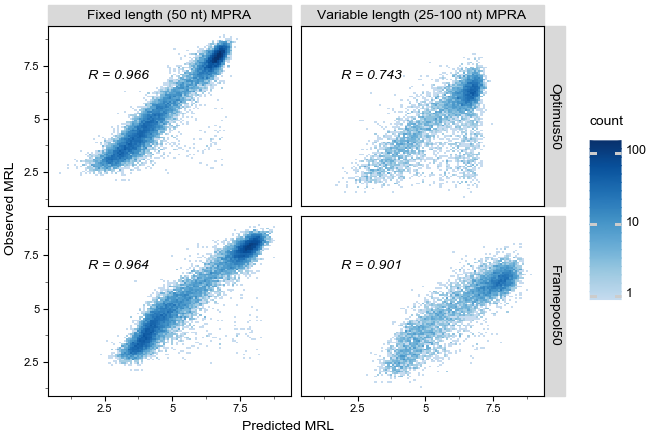

<ggplot: (-9223363250848419605)>

In [17]:
# Build a subset
mpra_pred_df_sub = mpra_pred_df[mpra_pred_df.model.isin(["Optimus50","Framepool50"])]

# Fix labels
plotlabel_dict = {"A": "Optimus50", "B": "Framepool50", "C": "Fixed length (50 nt) MPRA", "D": "Variable length (25-100 nt) MPRA"}
inv_plotlabel_dict = {v: k for k, v in plotlabel_dict.items()}
mpra_pred_df_sub["model_factor"] = mpra_pred_df_sub["model"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_df_sub["data_factor"] = mpra_pred_df_sub["data"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_R_df_sub = mpra_pred_df_sub[["model_factor", "data_factor", "R"]].drop_duplicates()
mpra_pred_R_df_sub["R"] = mpra_pred_R_df_sub["R"].apply(lambda x: "R = " + str(round(x,3)))
labeller = plotnine.facets.labelling.as_labeller(plotlabel_dict)

# Plot
p = (plotnine.ggplot(mpra_pred_df_sub, plotnine.aes('Predicted MRL', 'Observed MRL'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = 0.08)
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 #+ plotnine.labs(fill="")
 + plotnine.facet_grid('model_factor ~ data_factor', labeller = labeller)
 + plotnine.geom_text(size = 10, data = mpra_pred_R_df_sub, mapping = plotnine.aes(x = 3, y = 7, label = "R"), fontstyle = "italic")
 + plotnine.theme_matplotlib())
p

In [ ]:
#p.save("../Graphics/" + "Fig2" + ".svg", width=7.0, height=7.0*0.66)

#### Plot for MPRA human sequences

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


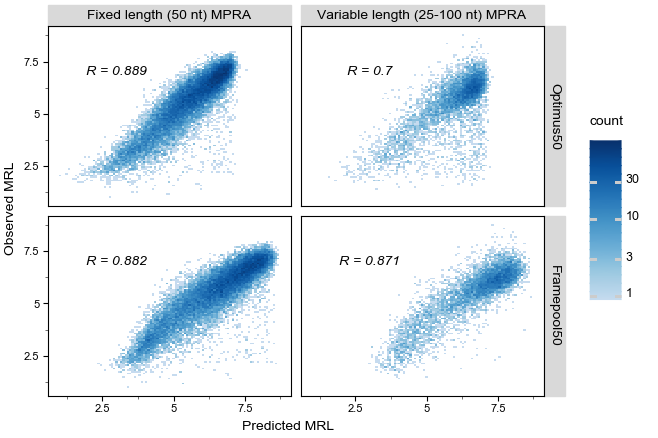

<ggplot: (8786005945955)>

In [18]:
# Build a subset
mpra_pred_df_sub = mpra_pred_df_human[mpra_pred_df_human.model.isin(["Optimus50","Framepool50"])]

# Fix labels
plotlabel_dict = {"A": "Optimus50", "B": "Framepool50", "C": "Fixed length (50 nt) MPRA", "D": "Variable length (25-100 nt) MPRA"}
inv_plotlabel_dict = {v: k for k, v in plotlabel_dict.items()}
mpra_pred_df_sub["model_factor"] = mpra_pred_df_sub["model"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_df_sub["data_factor"] = mpra_pred_df_sub["data"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_R_df_sub = mpra_pred_df_sub[["model_factor", "data_factor", "R"]].drop_duplicates()
mpra_pred_R_df_sub["R"] = mpra_pred_R_df_sub["R"].apply(lambda x: "R = " + str(round(x,3)))
labeller = plotnine.facets.labelling.as_labeller(plotlabel_dict)

# Plot
p = (plotnine.ggplot(mpra_pred_df_sub, plotnine.aes('Predicted MRL', 'Observed MRL'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = 0.08)
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 #+ plotnine.labs(fill="")
 + plotnine.facet_grid('model_factor ~ data_factor', labeller = labeller)
 + plotnine.geom_text(size = 10, data = mpra_pred_R_df_sub, mapping = plotnine.aes(x = 3, y = 7, label = "R"), fontstyle = "italic")
 + plotnine.theme_matplotlib())
p

In [ ]:
#p.save("../Graphics/" + "Fig2_human" + ".svg", width=7.0, height=7.0*0.66)

## **Validation on endogenous data**
We plot the performance of our models and Optimus models on endogenous data, split by sequence length

In [29]:
# build dataframe with data types, correlations and bootstrapping significance results
# Facet grid categories (for plotting):
splittype_1 = "Human 5'UTR shorter than longest training sequence"
splittype_2 = "Human 5'UTR longer than longest training sequence"
traintype_1 = "Trained on 50 nt MPRA"
traintype_2 = "Trained on 25-100 nt MPRA"

In [23]:
outputval_names = {"doudna": "rl_mean", "andreev":"log_load", "pcr3":"log_load", "eichhorn":"log_load",
                  "ptr":"ptr", "wilhelm":"ptr"}

# Function to compute predictions on endogenous data split by sequence length
def compute_split_metrics(data_dict, model, min_len=None, splits=[0, 100], extra_encoding_fn=[]):
    splits2 = splits[1:] + [1000000]
    result_dict = {str(split):{} for split in splits2[:-1]}
    result_dict["long"] = {}
    one_hot_fn = utils_data.OneHotEncoder("utr", min_len=min_len)
    for key in ["doudna", "andreev", "pcr3", "eichhorn", "ptr", "wilhelm"]:
        print("Analysing set: " + key)
        df = data_dict[key]
        for i in range(len(splits)):
            print("Analysing split from: " + str(splits[i]) + " to: " + str(splits2[i]))
            subset = df[(df.utr.str.len() > splits[i]) & (df.utr.str.len() <= splits2[i])]
            model_result = utils.compute_corrs(subset, model, one_hot_fn, key, extra_encoding_fn=extra_encoding_fn)
            total_corr = model_result["corr"]
            pred = model_result["pred"]
            if i == len(splits) - 1:
                result_key = "long"
            else:
                result_key = str(splits2[i])
            result_dict[result_key][key] = {"corr":(total_corr[0][0], total_corr[1][0]),
                                           "pred":pred.reshape(-1),
                                           "obs":np.array(subset[outputval_names[key]]).reshape(-1)}
    return result_dict

In [30]:
# build dataframe with data types, correlations and bootstrapping significance results
def corr_wrapper(pred, obs, corr = "pearson"):
    if corr == "pearson":
        return stats.pearsonr(pred, obs)[0]
    else:
        return stats.spearmanr(pred, obs)[0]

# Function to perform the bootstrapping
def do_bootstrap(df, n_samples=100, std_factor=stats.norm.ppf(0.9998), corr = "pearson"):
    our_bootstrap = []
    paper_bootstrap = []
    for i in range(n_samples):
        sub = df.sample(frac=1, replace=True)
        our_bootstrap.append(corr_wrapper(sub["pred_our"], sub["obs_our"], corr = corr))
        paper_bootstrap.append(corr_wrapper(sub["pred_paper"], sub["obs_paper"], corr = corr))
    diff = [x - y for x,y in zip(our_bootstrap, paper_bootstrap)]
    mean_diff = np.mean(diff)
    error_diff = np.std(diff)*std_factor
    sig = "Significant"
    if mean_diff < 0 and mean_diff + error_diff > 0:
        sig = "Not " + sig
    elif mean_diff > 0 and mean_diff - error_diff < 0:
        sig = "Not " + sig
    return sig

# Function to perform bootstrapping and build dataframe with metrics
def build_bootstrapped_split_metrics():
    datalabels_dict = {"doudna":"Floor", "andreev":"Andreev", "pcr3":"Xiao", "eichhorn":"Eichhorn", "ptr":"Eraslan", "wilhelm":"Wilhelm"}
    datatype_dict = {"doudna":"Trip-seq", "andreev":"Ribo-seq", "pcr3":"Ribo-seq", "eichhorn":"Ribo-seq", "ptr":"PTR", "wilhelm":"PTR"}
    splittype_dict = {"50": splittype_1, 
                      "100": splittype_1,
                     "long": splittype_2}
    traindatatype_dict = {"50": traintype_1, 
                          "100": traintype_2}
    rows_list = []
    for comparison in [("Optimus50", "Framepool50", "50"), ("Optimus100", "Framepool100", "100")]:
        for split in [comparison[2], "long"]:
            for data in ["doudna", "andreev", "pcr3", "eichhorn", "ptr", "wilhelm"]:
                bootstrap_df = pd.DataFrame({"pred_paper": metricname_dict[comparison[0]][split][data]["pred"],
                        "obs_paper":metricname_dict[comparison[0]][split][data]["obs"],
                        "pred_our":metricname_dict[comparison[1]][split][data]["pred"],
                        "obs_our":metricname_dict[comparison[1]][split][data]["obs"]})
                r_optimus = stats.pearsonr(bootstrap_df["pred_paper"], bootstrap_df["obs_paper"])[0]
                r_framepool = stats.pearsonr(bootstrap_df["pred_our"], bootstrap_df["obs_our"])[0]
                rho_optimus = stats.spearmanr(bootstrap_df["pred_paper"], bootstrap_df["obs_paper"])[0]
                rho_framepool = stats.spearmanr(bootstrap_df["pred_our"], bootstrap_df["obs_our"])[0]
                sig = do_bootstrap(bootstrap_df, corr = "pearson")
                sig_rho = do_bootstrap(bootstrap_df, corr = "spearman")
                row = {"Pearson's R of Optimus predictions with observed values": r_optimus,
                      "Pearson's R of Framepool predictions with observed values": r_framepool,
                       "Spearman's rho of Optimus predictions with observed values": rho_optimus,
                      "Spearman's rho of Framepool predictions with observed values": rho_framepool,
                       "significant_diff_Pearson": sig,
                       "significant_diff_Spearman": sig_rho,
                      "data": datalabels_dict[data],
                      "data_type": datatype_dict[data],
                      "split_type": splittype_dict[split],
                      "train_data_type": traindatatype_dict[comparison[2]]}
                rows_list.append(row)
    return pd.DataFrame(rows_list)

#### Compute split metrics

In [31]:
# Compute the metrics
split_metrics_path = Path("../Data/Predictions/split_metric_df.csv")
if not os.path.exists(Path("../Data/Predictions/split_metric_df.csv")):
    #metrics_split_optimus_50 = compute_split_metrics(data_dict, paper_model, min_len=50, splits=[0, 50])
    #metrics_split_frameslice_50 = compute_split_metrics(data_dict, utr_model_50, splits=[0, 50])
    #metrics_split_optimus_100 = compute_split_metrics(data_dict, paper_model2, min_len=100)
    #metrics_split_frameslice_100 = compute_split_metrics(data_dict, utr_model)
    #metrics_split_frameslice_combined = compute_split_metrics(
    #    data_dict, utr_model_combined, extra_encoding_fn=[library_fn])
    metricname_dict = {"Optimus50": metrics_split_optimus_50, "Framepool50": metrics_split_frameslice_50,
                  "Optimus100": metrics_split_optimus_100, "Framepool100": metrics_split_frameslice_100}
    # Save computed metrics
    with open(Path("../Data/Metrics/metrics_split_optimus_50_dict.pkl"), 'wb') as handle:
        pickle.dump(metrics_split_optimus_50, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(Path("../Data/Metrics/metrics_split_frameslice_50_dict.pkl"), 'wb') as handle:
        pickle.dump(metrics_split_frameslice_50, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(Path("../Data/Metrics/metrics_split_optimus_100_dict.pkl"), 'wb') as handle:
        pickle.dump(metrics_split_optimus_100, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(Path("../Data/Metrics/metrics_split_frameslice_100_dict.pkl"), 'wb') as handle:
        pickle.dump(metrics_split_frameslice_100, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(Path("../Data/Metrics/metrics_split_frameslice_combined_dict.pkl"), 'wb') as handle:
        pickle.dump(metrics_split_frameslice_combined, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # Assemble into dataframe
    split_metric_df = build_bootstrapped_split_metrics()
    # save
    split_metric_df.to_csv(Path("../Data/Predictions/split_metric_df.csv"))

#### Plot split metrics

In [32]:
split_metric_df = pd.read_csv(Path("../Data/Predictions/split_metric_df.csv"))

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/plotnine/scales/scale_alpha.py:70: PlotnineWarning: Using alpha for a discrete variable is not advised.
  PlotnineWarning
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 1 rows con

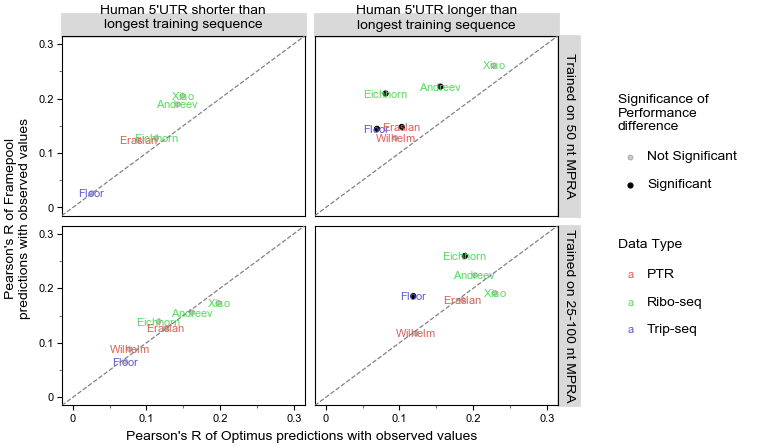

<ggplot: (-9223363250932581372)>

In [33]:
# Make categoricals for values used to order facet grid
split_metric_df['split_type_cat'] = pd.Categorical(split_metric_df['split_type'], categories=[splittype_1,splittype_2])
split_metric_df['train_type_cat'] = pd.Categorical(split_metric_df['train_data_type'], categories=[traintype_1,traintype_2])

# Labels
x_lab = "Pearson's R of Optimus predictions with observed values"
y_lab = "Pearson's R of Framepool\npredictions with observed values"
plotlabel_dict = {traintype_1: "Trained on 50 nt MPRA", traintype_2: "Trained on 25-100 nt MPRA", 
                  splittype_1: "Human 5'UTR shorter than\nlongest training sequence\n", 
                  splittype_2: "Human 5'UTR longer than\nlongest training sequence\n"}
labeller = plotnine.facets.labelling.as_labeller(plotlabel_dict) # facet labeller

# Adjust text parameters
"""adjust_text_dict = {
    'x': split_metric_df["Pearson's R of Optimus predictions with observed values"],
    'y': split_metric_df["Pearson's R of Framepool predictions with observed values"],
    "expand_text": (2,2),
    "avoid_point": True,
    "avoid_text": True,
    #'expand_points': (2, 2)
    #'arrowprops': {
    #    'arrowstyle': '->',
    #    'color': 'red'
    #}
}"""

# Plot
p = (plotnine.ggplot(split_metric_df, plotnine.aes("Pearson's R of Optimus predictions with observed values", 
                                                    "Pearson's R of Framepool predictions with observed values"))
 + plotnine.geom_point(plotnine.aes(alpha="significant_diff_Pearson"))
 + plotnine.scale_alpha_discrete(range = [0.2, 1.0])
 + plotnine.scales.scale_shape_manual(values=["o", "^", "v"])
 + plotnine.geom_text(plotnine.aes(label="data", color="data_type"), parse=True, size=8)
 + plotnine.xlab(x_lab)
 + plotnine.ylab(y_lab) 
 + plotnine.xlim(0, 0.3) 
 + plotnine.ylim(0, 0.3)
 + plotnine.labs(alpha="Significance of\nPerformance\ndifference", shape="Data Type", color="Data Type")
 + plotnine.facet_grid('train_type_cat ~ split_type_cat', labeller=labeller)
 + plotnine.geom_abline(color="grey", linetype="--")
 + plotnine.theme_matplotlib()
 + plotnine.theme(strip_background=plotnine.element_rect(size=2)))
p

In [ ]:
#p.save("../Graphics/" + "Fig3" + ".svg")

## **TIS Strength validation**
We prepare and run our in-silico experiment to evaluate our model's understanding of uTIS motifs

#### Load data

In [34]:
if not os.path.exists(Path("../Data/Predictions/aug_predictions.csv")) or not os.path.exists(Path("../Data/Predictions/nonaug_predictions.csv")):
    noderer_df_aug = pd.read_csv(Path("../Data/TIS/tis_efficiencies_aug.tsv"), sep='\t')
    noderer_df_aug = noderer_df_aug.rename(index=str, columns={"sequence":"TIS_Sequence", "efficiency":"TIS_Efficiency"})
    noderer_df_nonaug = pd.read_csv(Path("../Data/TIS/tis_efficiencies_nonaug.tsv"), sep='\t')
    # Recode U to T
    noderer_df_aug["TIS_Sequence"] = noderer_df_aug["TIS_Sequence"].str.replace("U", "T")
    noderer_df_nonaug["TIS_Sequence"] = noderer_df_nonaug["TIS_Sequence"].str.replace("U", "T")
    # Prepare AUG data for injection
    noderer_df_aug["TIS_Sequence_AGG"] = [seq[:7] + "G" + seq[8:] for seq in noderer_df_aug["TIS_Sequence"]]
    bad_end = noderer_df_aug["TIS_Sequence"].str.endswith("AT")
    double_trouble = noderer_df_aug["TIS_Sequence_AGG"].str.contains("ATG")
    noderer_df_aug_sub = noderer_df_aug[(~bad_end) & (~double_trouble)]
    noderer_df_aug = noderer_df_aug_sub
    # Prepare nonaug data for injection
    # Remove AUG creating motifs
    atg_trouble = noderer_df_nonaug["TIS_Sequence"].str.contains("ATG")
    noderer_df_nonaug = noderer_df_nonaug[~atg_trouble]

#### Compute predicted impact of AUG TIS motifs

In [35]:
# run prediction
if not os.path.exists(Path("../Data/Predictions/aug_predictions.csv")):
    # select which model to use
    model_to_apply = utr_model_combined
    # prepare run
    extra_encoding_fn = [library_fn]
    one_hot_fn_inactive = utils_data.OneHotEncoder("wt")
    one_hot_fn_active = utils_data.OneHotEncoder("snv")
    samples = 100
    diffs = []
    # run
    for i in range(samples):
        prefix = ''.join(random.choices(["C","T","G"], k=9)) # fast way to get AUG free seq 
        suffix = ''.join(random.choices(["C","T","G"], k=9)) # fast way to get AUG free seq
        noderer_df_aug["snv"] = [prefix + seq + suffix for seq in
                                                noderer_df_aug["TIS_Sequence"]]
        noderer_df_aug["wt"] = [prefix + seq + suffix for seq in
                                            noderer_df_aug["TIS_Sequence_AGG"]]
        gen_wt = utils_data.DataSequence(noderer_df_aug, encoding_functions=[one_hot_fn_inactive] + extra_encoding_fn, 
                                         shuffle=False)
        predict_wt_only = model_to_apply.predict_generator(gen_wt, verbose=0)
        gen_snv = utils_data.DataSequence(noderer_df_aug, encoding_functions=[one_hot_fn_active] + extra_encoding_fn, 
                                          shuffle=False)
        predict_snv_only = model_to_apply.predict_generator(gen_snv, verbose=0)
        log_pred_diff_only = np.log2(predict_snv_only/predict_wt_only)
        diffs.append(log_pred_diff_only)
    diffs = sum(diffs)/len(diffs)
    noderer_df_aug["Predicted log2 Fold Change"] = diffs.reshape(-1)
    noderer_df_aug["PredFC"] = (2 ** noderer_df_aug["Predicted log2 Fold Change"])*100 - 100
    noderer_df_aug["codon"] = "AUG"
    noderer_df_aug_reduced = noderer_df_aug[['TIS_Sequence', 'TIS_Efficiency', "PredFC", "codon"]]
    print(stats.pearsonr(noderer_df_aug["TIS_Efficiency"], diffs.reshape(-1)))
    print(stats.spearmanr(noderer_df_aug["TIS_Efficiency"], diffs.reshape(-1)))
    noderer_df_aug_reduced.to_csv(Path("../Data/Predictions/aug_predictions.csv"))

(-0.7889159961269612, 0.0)
SpearmanrResult(correlation=-0.7610619194844421, pvalue=0.0)


#### Compute predicted impact of non-AUG TIS motifs

In [36]:
# make random seq without AUG
def random_seq_noaug(exclude_motifs=["CTG","GTG"]):
    seq = ''.join(random.choices(["A","C","T","G"], k=9))
    # (try to) clean out unwanted motifs that could eat results
    for motif in exclude_motifs:
        motifs_present = [m.start() for m in re.finditer(motif, seq)]
        for idx in motifs_present:
            seq = seq[:idx] + ''.join(random.choices(["A","C","T","G"], k=2)) + seq[idx+3:]
    # (surely) clean out atg, since they dominate everything
    atg_present = [m.start() for m in re.finditer('ATG', seq)]
    for idx in atg_present:
        seq = seq[:idx] + "C" + ''.join(random.choices(["C","T","G"], k=2)) + seq[idx+3:]
    return seq
    
# Predict
if not os.path.exists(Path("../Data/Predictions/nonaug_predictions.csv")):
    # Select model and prepare run
    extra_encoding_fn = [library_fn]
    model_to_apply = utr_model_combined
    nonaug_dict = {key:noderer_df_nonaug[noderer_df_nonaug["TIS_Sequence"].str[-4:-1] == key] for key in
                   set(noderer_df_nonaug["TIS_Sequence"].str[-4:-1])}
    key_to_inactive = {'CTG':"CTT", 'ACG':"ACT", 'AAG':"AAC", 'GTG':"GTT", 
                       'ATA':"ACT", 'AGG':"AGT", 'ATT':"GTT", 'ATC':"GTC", 
                       'TTG':"TTT"}
    one_hot_fn_inactive = utils_data.OneHotEncoder("wt")
    one_hot_fn_active = utils_data.OneHotEncoder("snv")
    samples = 100
    # Run
    for key in nonaug_dict.keys():
        nonaug_dict[key]["TIS_inactive"] = [seq[:-4] + key_to_inactive[key] + seq[-1] for seq in
                                            nonaug_dict[key]["TIS_Sequence"]]
        diff_list = []
        for i in range(samples):
            prefix = random_seq_noaug()
            suffix = random_seq_noaug()
            nonaug_dict[key]["snv"] = [prefix + seq + suffix for seq in
                                                nonaug_dict[key]["TIS_Sequence"]]
            nonaug_dict[key]["wt"] = [prefix + seq + suffix for seq in
                                            nonaug_dict[key]["TIS_inactive"]]
            gen_wt = utils_data.DataSequence(nonaug_dict[key], encoding_functions=[one_hot_fn_inactive] + extra_encoding_fn, 
                                             shuffle=False)
            predict_wt_nonaug = model_to_apply.predict_generator(gen_wt, verbose=0)
            gen_snv = utils_data.DataSequence(nonaug_dict[key], encoding_functions=[one_hot_fn_active] + extra_encoding_fn, 
                                              shuffle=False)
            predict_snv_nonaug = model_to_apply.predict_generator(gen_snv, verbose=0)
            log_pred_diff_nonaug = np.log2(predict_snv_nonaug/predict_wt_nonaug)
            diff_list.append(log_pred_diff_nonaug)
        print("iteration done")
        diffs = sum(diff_list)/len(diff_list)    
        nonaug_dict[key]["Predicted log2 Fold Change"] = diffs
    # Combine
    df_list = []
    for key in nonaug_dict.keys():
        if key not in ["CTG", "GTG"]:
            continue
        nonaug_dict[key]["codon"] = key.replace("T","U")
        nonaug_dict[key]["PredFC"] = (2 ** nonaug_dict[key]["Predicted log2 Fold Change"])*100 - 100
        df_list.append(nonaug_dict[key][['TIS_Sequence', 'TIS_Efficiency', "PredFC", "codon"]])
    combined_nonaug = pd.concat(df_list)
    # Save
    combined_nonaug.to_csv(Path("../Data/Predictions/nonaug_predictions.csv"))

iteration done
iteration done
iteration done
iteration done
iteration done
iteration done
iteration done
iteration done
iteration done


#### Load all datasets, combine and plot in combined plot

In [37]:
# Read AUG data
noderer_df_aug_reduced = pd.read_csv(Path("../Data/Predictions/aug_predictions.csv"))
# Read Non aug data
combined_nonaug = pd.read_csv(Path("../Data/Predictions/nonaug_predictions.csv"))

# combine
combined_codon_df = pd.concat([noderer_df_aug_reduced, combined_nonaug])
# copy
all_df = combined_codon_df.copy()
allname = "Combined"
all_df["codon"] = allname
# combine with copy
combined_all = pd.concat([all_df, combined_codon_df[combined_codon_df.codon.isin(["AUG", "CUG", "GUG"])]])


# compute correlations
codon_keys = [allname, "AUG", "CUG", "GUG"]
r_list = []
for key in codon_keys:
    subcodon_df = combined_all[combined_all.codon == key]
    r = "R = " + str(round(stats.pearsonr(subcodon_df["TIS_Efficiency"], subcodon_df["PredFC"])[0], 3))
    r_list.append(r)
r_dat = pd.DataFrame({"codon":codon_keys,"r":r_list})

In [38]:
r_dat

,codon,r
0,Combined,R = -0.844
1,AUG,R = -0.797
2,CUG,R = -0.656
3,GUG,R = -0.264


/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed

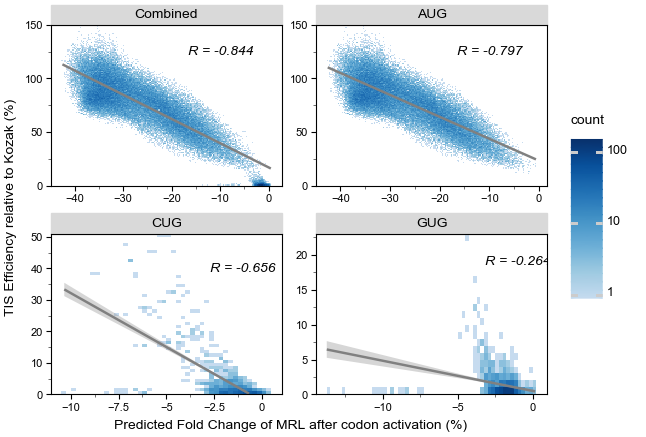

<ggplot: (8785662228372)>

In [39]:
combined_all['codon_cat'] = pd.Categorical(combined_all['codon'], categories=codon_keys)
r_dat['codon_cat'] = pd.Categorical(r_dat['codon'], categories=codon_keys)
r_dat["x_pos"] = [-10, -10, -1, -1]
r_dat["y_pos"] = [125, 125, 40, 19]

# Plot
p = (plotnine.ggplot(combined_all, plotnine.aes('PredFC', 'TIS_Efficiency'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = [0.25,1])
 + plotnine.scale_y_continuous(limits = (0, float("NaN")), expand=(0,0))
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 #+ plotnine.labs(fill="")
 + plotnine.xlab("Predicted Fold Change of MRL after codon activation (%)")
 + plotnine.ylab("TIS Efficiency relative to Kozak (%)")
 #+ plotnine.scale_x_continuous(trans='log10')
 #+ plotnine.annotation_logticks(sides="b")
 + plotnine.stat_smooth(method='lm', color="grey")
 + plotnine.facet_wrap("codon_cat", scales="free")
 + plotnine.geom_text(size = 10, data = r_dat, mapping = plotnine.aes(x = "x_pos", y = "y_pos", label = "r"), fontstyle = "italic")
 + plotnine.theme_matplotlib()
 + plotnine.theme(subplots_adjust={'wspace':0.15, "hspace":0.3}))
 #+ plotnine.theme(legend_direction="horizontal", legend_position = (0.75, 0.80)))
p

In [ ]:
#p.save("../Graphics/" + "Fig5_combined" + ".svg")

## **Conservation: PhyloP score validation**
We predict the effect of all possible snv in loss of of function genes and compare it to the phyloP conservation scores

#### Prepare functions

In [40]:
# Function to create an in-silico SNP array
nuc_dict = {'a':[1.0,0.0,0.0,0.0],'c':[0.0,1.0,0.0,0.0],'g':[0.0,0.0,1.0,0.0], 'u':[0.0,0.0,0.0,1.0], 
            't':[0.0,0.0,0.0,1.0], 'n':[0.0,0.0,0.0,0.0], 'x':[1/4,1/4,1/4,1/4]}
permutation_array = np.array([[1.0,0.0,0.0,0.0], [0.0,1.0,0.0,0.0], [0.0,0.0,1.0,0.0], [0.0,0.0,0.0,1.0]])

def write_conservation_scores(pos_df, bw, path=Path("../Data/Predictions/phylop/")):
    if not os.path.exists(path):
        os.makedirs(path)
    for i in range(len(pos_df)):
        row = pos_df.iloc[i]
        scores = [bw.values(row["chr"], x[0], x[1]) for x in eval(row["pos"])]
        scores = np.array(list(itertools.chain.from_iterable(scores)))
        np.save(path / ("phyloP_" + row["EnsemblTranscriptID"] + ".npy"), scores)

def create_permutations(seq, min_len=None):
    n = len(seq) * 4
    seq = seq.lower()
    one_hot = np.array([nuc_dict[x] for x in seq])
    one_hot_permuted = np.repeat(one_hot[np.newaxis,:,:], n, axis=0)
    for i in range(len(seq)):
        one_hot_permuted[i*4:(i*4)+4,i] = permutation_array
    if min_len is not None:
        diff = min_len - len(seq)
        if diff > 0:
            padding = np.zeros((n+1,diff, 4))
            one_hot_permuted = np.concatenate([one_hot[np.newaxis,:,:], one_hot_permuted], axis=0)
            one_hot_permuted = np.concatenate([padding, one_hot_permuted], axis=1)
        if diff < 0:
            one_hot_permuted = one_hot_permuted[np.abs(diff)*4:,np.abs(diff):,:]
            one_hot_permuted = np.concatenate([one_hot[np.newaxis,np.abs(diff):,:], one_hot_permuted], axis=0)
        if diff == 0:
            one_hot_permuted = np.concatenate([one_hot[np.newaxis,:,:], one_hot_permuted], axis=0)
    else:
        one_hot_permuted = np.concatenate([one_hot[np.newaxis,:,:], one_hot_permuted], axis=0)
    return one_hot_permuted

def create_snv_array(seq, model, min_len=None,
                     postproc_mean=5.269942112451139, postproc_sd=1.3551744190850261,
                    add_frame=False, add_library=False, suppress_postproc=False):
    if add_frame:
        frame = utils.build_frame(len(seq), (len(seq)*4) + 1)
        predictions = model.predict([create_permutations(seq, min_len=min_len), frame])
    elif add_library:
        indicator = np.zeros(((len(seq)*4) + 1,2))
        indicator[:,1] = 1
        predictions = model.predict([create_permutations(seq, min_len=min_len), indicator])
    else:
        predictions = model.predict(create_permutations(seq, min_len=min_len))
    if min_len is not None and not suppress_postproc:
        predictions =  predictions * postproc_sd + postproc_mean
    delta = np.log2(predictions[1:]/predictions[0])
    if min_len is not None and len(seq) > min_len:
        delta = delta.reshape((min_len, 4))
        diff = len(seq) - min_len
        padding = np.zeros((diff, 4))
        delta = np.concatenate([padding, delta], axis=0)
    else:
        delta = delta.reshape((len(seq), 4))
    return delta

def write_arrays(df, model, path, min_len=None, add_frame=False, add_library=False,
                 suppress_postproc=False,
                check_and_skip=False):
    if not os.path.exists(path):
        os.makedirs(path)
    for seq_id, seq in zip(df["EnsemblTranscriptID"], df["utr"]):
        if len(seq) == 1:
            continue
        if check_and_skip and os.path.exists(path / ("SNPdelta_" + seq_id + ".npy")):
            continue
        delta = create_snv_array(seq, model, min_len=min_len, add_frame=add_frame, add_library=add_library,
                                suppress_postproc=suppress_postproc)
        np.save(path / ("SNPdelta_" + seq_id + ".npy"), np.transpose(delta))

def read_array(pos_df, transcript_id, base_path = Path("../Data/Predictions/"),
              snv_path=Path("Genecode_v19_new/"), cons_path=Path("phylop/")):
    array = np.load(base_path / snv_path / ("SNPdelta_" + transcript_id + ".npy"))
    pos = pos_df[pos_df.EnsemblTranscriptID == transcript_id].iloc[0]
    indices = np.concatenate([np.arange(x[0],x[1]) for x in eval(pos["pos"])])
    atg_dist = np.flip(np.arange(len(indices))) + 1
    conservation = np.load(base_path / cons_path / ("phyloP_" + transcript_id + ".npy"))
    if pos["strand"] == "-":
        indices = np.flip(indices)
        conservation = np.flip(conservation)
    return pd.DataFrame({"EnsemblTranscriptID":pos["EnsemblTranscriptID"], 
                         "chr":pos["chr"], "strand":pos["strand"], "pos_ensembl":indices+1,
                         "dist_to_atg":atg_dist,
                         "conservation":conservation,
                        "A":array[0,:],"C":array[1,:],"G":array[2,:],"T":array[3,:]})

def read_all_arrays(pos_df, snv_path=Path("Genecode_v19_frameslice_100/")):
    data = []
    i = 0
    for transcript_id in pos_df["EnsemblTranscriptID"]:
        arr = read_array(pos_df, transcript_id, snv_path=snv_path)
        data.append(arr)
        if i % 1000 == 0:
            print(i)
        i += 1
    arr = pd.concat(data)
    return arr

#### Load needed data

In [41]:
seq_df = pd.read_csv(Path("../Data/gencodev19_5utr_seq.csv"))
pos_df = pd.read_csv(Path("../Data/gencodev19_5utr_pos.csv"))
# remove length 1 utrs, as they can not yield sensible predictions and only mess with numpy
seq_df = seq_df[seq_df["utr"].str.len() > 1]
pos_df = pos_df[pos_df["EnsemblTranscriptID"].
                isin(seq_df[seq_df["utr"].str.len() > 1]["EnsemblTranscriptID"])]
# reduce to lof intolerant genes
# Lof intolerant: "oe_lof_upper" < 0.35
lof_df = pd.read_csv(Path("../Data/gencodev19_5utr_lof.bed"), sep="\t",
                     names=["chr", "start", "stop", "EnsemblTranscriptID", "?", "strand"])
pos_df = pos_df[pos_df["EnsemblTranscriptID"].isin(lof_df["EnsemblTranscriptID"])]
seq_df = seq_df[seq_df["EnsemblTranscriptID"].isin(lof_df["EnsemblTranscriptID"])]

#### Prepare phyloP data
**If you want to rerun this, you need to download the hg19 100way phylop bigwig file from ucsc**

In [31]:
if not os.path.exists(Path("../Data/Predictions/phylop/")):
    import pyBigWig
    import pysam
    phylop_path = Path("/s/genomes/human/hg19/conservation/phyloP/hg19.100way.phyloP100way.bw")
    bw = pyBigWig.open(phylop_path)
    write_conservation_scores(pos_df, bw)

#### Compute and Write all snv effects for all 5'UTR of lof transcripts

In [32]:
# write for framepool model
if not os.path.exists(Path("../Data/Predictions/Genecode_v19_frameslice_100/")):
    write_arrays(seq_df, utr_model, Path("../Data/Predictions/Genecode_v19_frameslice_100/"))
# write for framepool model with truncation
if not os.path.exists(Path("../Data/Predictions/Genecode_v19_frameslice_100_truncated/")):
    write_arrays(seq_df, utr_model, Path("../Data/Predictions/Genecode_v19_frameslice_100_truncated/"), min_len=100, suppress_postproc=True)
# write arrays for paper model with truncation
if not os.path.exists(Path("../Data/Predictions/Genecode_v19_paper_truncated_rescale/")):
    write_arrays(seq_df, paper_model2, 
                    Path("../Data/Predictions/Genecode_v19_paper_truncated_rescale/"), min_len=100)

#### Load results

In [35]:
# results for our model (framepool100), untruncated sequences
arr = read_all_arrays(pos_df)

0
1000
2000
3000
4000
5000
6000
7000
8000


In [36]:
# results for our model on truncated sequences
arr_truncated = read_all_arrays(pos_df, snv_path=Path("Genecode_v19_frameslice_100_truncated/"))

0
1000
2000
3000
4000
5000
6000
7000
8000


In [37]:
# results for the optimus100 model on truncated sequences
arr_paper_truncated = read_all_arrays(pos_df, snv_path=Path("Genecode_v19_paper_truncated_rescale/"))

0
1000
2000
3000
4000
5000
6000
7000
8000


In [38]:
# concatenate dataframes
arr_far = arr[arr["dist_to_atg"] > 100]
arr_far["model"] = "Framepool100"
arr_far["data"] = ">100nt from canonical AUG"
arr_truncated = arr_truncated[arr_truncated["dist_to_atg"] <= 100]
arr_truncated["model"] = "Framepool100"
arr_truncated["data"] = "within 100nt of canonical AUG"
arr_paper_truncated = arr_paper_truncated[arr_paper_truncated["dist_to_atg"] <= 100]
arr_paper_truncated["model"] = "Optimus100"
arr_paper_truncated["data"] = "within 100nt of canonical AUG"
snveffect_df = pd.concat([arr_far, arr_truncated, arr_paper_truncated])
# compute the average absolute fold change
snveffect_df["avg_effect"] = np.sum(np.abs(np.array(snveffect_df[["A","C","G","T"]])), axis = 1)/3

In [39]:
# average for identical position over different transcripts
id_col = list(zip(snveffect_df["model"], snveffect_df["data"],
                        snveffect_df["chr"], snveffect_df["pos_ensembl"]))
snveffect_df["id_col"] = id_col
snveffect_posaggreg = snveffect_df.groupby("id_col").agg({'avg_effect': 'mean', "conservation": "max"})
snveffect_posaggreg["model"] = [x[0] for x in snveffect_posaggreg.index]
snveffect_posaggreg["data"] = [x[1] for x in snveffect_posaggreg.index]
snveffect_posaggreg["chr"] = [x[2] for x in snveffect_posaggreg.index]
snveffect_posaggreg["pos_ensembl"] = [x[3] for x in snveffect_posaggreg.index]
snveffect_posaggreg = snveffect_posaggreg.reset_index()[["avg_effect", "conservation", 
                                                         "model", "data", "chr", "pos_ensembl"]]
snveffect_posaggreg["avg_effect_FC"] =  ((2 ** snveffect_posaggreg["avg_effect"]) * 100) - 100

In [40]:
# compute averages
avg_within100nt = snveffect_posaggreg[snveffect_posaggreg.data == "within 100nt of canonical AUG"]["conservation"].mean()
avg_far = snveffect_posaggreg[snveffect_posaggreg.data == ">100nt from canonical AUG"]["conservation"].mean()
df_avgphylop = pd.DataFrame({"data": ["within 100nt of canonical AUG", ">100nt from canonical AUG"], 
                             "average conservation": [avg_within100nt, avg_far]})

In [41]:
cuts = [0, 10, 25, 50, 100]
bin_labels = ["<10", "10-25", "25-50", "50-100", ">100"]

# bin the data
def bin_data(cuts, labels, score_col="avg_effect_FC"):
    df_list = []
    for model in ["Optimus100", "Framepool100"]:
        for data in ["within 100nt of canonical AUG", ">100nt from canonical AUG"]:
            df = snveffect_posaggreg[(snveffect_posaggreg.model == model) & (snveffect_posaggreg.data == data)]
            if len(df) == 0:
                continue
            cuts2 = cuts[1:] + [100000]
            binned_phylop = []
            binned_error = []
            binned_counts = []
            for i in range(len(labels)):
                l = cuts[i]
                u = cuts2[i]
                sub_df = df[(df[score_col] < u) & (df[score_col] > l)]
                binned_phylop.append(sub_df["conservation"].mean())
                binned_error.append(sub_df["conservation"].sem() * stats.t.ppf(0.975,len(sub_df)))
                binned_counts.append(len(sub_df))
            binned_df = pd.DataFrame({"bin":labels, "PhyloP":binned_phylop, "CI":binned_error, "count":binned_counts,
                                     "model":model, "data":data})
            df_list.append(binned_df)
    return pd.concat(df_list)

binned_df = bin_data(cuts, bin_labels)

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


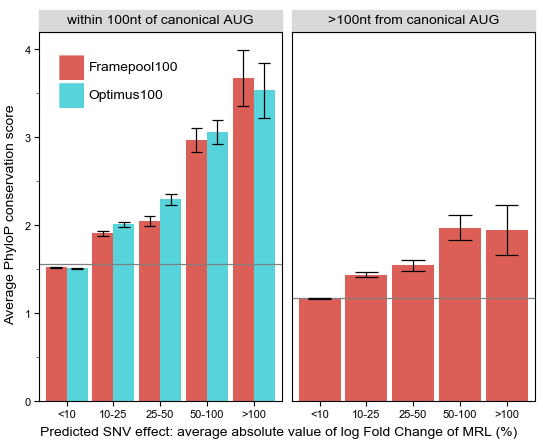

<ggplot: (-9223363268269979034)>

In [42]:
binned_df['Predicted absolute FC (%)'] = pd.Categorical(binned_df['bin'], categories=bin_labels)
binned_df['data_cat'] = pd.Categorical(binned_df['data'], categories=["within 100nt of canonical AUG", ">100nt from canonical AUG"])
df_avgphylop['data_cat'] = pd.Categorical(df_avgphylop['data'], categories=["within 100nt of canonical AUG", ">100nt from canonical AUG"])

p = (plotnine.ggplot(binned_df, plotnine.aes(fill="model", y="PhyloP", x="Predicted absolute FC (%)")) + 
plotnine.geom_bar(position="dodge", stat="identity") + 
 plotnine.xlab("Predicted SNV effect: average absolute value of log Fold Change of MRL (%)") +
 plotnine.scale_y_continuous(expand = (0,0), limits = (0,4.2)) + 
 plotnine.ylab("Average PhyloP conservation score") +
 plotnine.labs(fill="") +
 plotnine.facet_wrap("data_cat") +
plotnine.geom_hline(data=df_avgphylop, mapping=plotnine.aes(yintercept="average conservation"), color="gray") + 
plotnine.geom_errorbar(plotnine.aes(ymin="PhyloP-CI", ymax="PhyloP+CI"), position=plotnine.positions.position_dodge(width=0.9), 
                       colour="black") + 
plotnine.theme_matplotlib() +
plotnine.theme(legend_position = (0.25, 0.8)))
p

In [ ]:
#p.save("../Graphics/" + "Fig4" + ".svg")